In [15]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load Italy data

In [82]:
link = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
data = pd.read_csv(link)
print('run at: {}'.format(datetime.date.today()))
print('first case: 2020-01-29') # first case in Italy is January 29
days = 65 # give or take...

run at: 2020-04-05
first case: 2020-01-29


# Italy beta profile

In [83]:
data.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,7,229,4324,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,10,322,8623,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,12,400,9587,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,17,650,12014,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,21,888,15695,NaN,NaN


In [84]:
I = data['totale_positivi'].values
I

array([  221,   311,   385,   588,   821,  1049,  1577,  1835,  2263,
        2706,  3296,  3916,  5061,  6387,  7985,  8514, 10590, 12839,
       14955, 17750, 20603, 23073, 26062, 28710, 33190, 37860, 42681,
       46638, 50418, 54030, 57521, 62013, 66414, 70065, 73880, 75528,
       77635, 80572, 83049, 85388, 88274])

In [165]:
def convolve(x, k=1):
    # np adds padding by default, we remove the edges
    if k == 1:
        return x
    f = [1/k] * k
    return np.convolve(x, f)[k-1:1-k]

def get_beta(i, gamma = 1/14):
    # we assume S(t)/n ~ 1 for this phase 
    di = i[1:] - i[:-1] # delta_i
    beta = di  / i[:-1] + gamma
    return beta

def doubling_rate(I, window=5):
    growth_rate = np.exp(np.diff(np.log(I))) - 1
    growth_rate = growth_rate[-window:]
    doubling_time = np.log(2) / growth_rate
    return doubling_time.mean()

def fit_exponent(I):
    beta = get_beta(I)
    
    # time in days since first case
    t = np.linspace(1, days, days)
    t_ = t[-len(beta):] 
    
    # line fit to loglog data
    x, y = np.log(t_), np.log(beta - 1/14 + 0.000001)
    A = np.vstack([x, np.ones(len(x))]).T
    res = np.linalg.lstsq(A, y, rcond=None) 
    return x, y, res

def plot(x, I, beta):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax2 = ax.twinx()

    ax.set_title('Italy cases and betas')
    ax.set_xlabel('days back from today')
    ax.set_ylabel('beta - blue')
    l1 = ax.plot(-x[:-1][::-1] - 1, beta, marker='o', lw=0.5, label='beta')
    ax2.set_ylabel('cases - red')
    l2 = ax2.plot(-x[::-1] - 1, I, c='r', marker='x', lw=0.5, label='cases')
    ax2.set_yscale('log') # log scale
    lns = l1 + l2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=2)
    
    plt.show()

def plot_fit(I):
    x, y, res = fit_exponent(I)
    slope, intercept = res[0]
    line = [slope * i + intercept for i in x]

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(2, 2, 1)
    ax.plot(x, line, 'r')
    ax.plot(x, y, lw=0.5, marker='x')
    ax.set_title('loglog | slope: {:0.03f} & intercept: {:0.03f}'.format(slope, intercept))
    
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(np.exp(x), np.exp(line), 'r')
    ax2.plot(np.exp(x), np.exp(y), lw=0.5, marker='x')
    ax2.set_title('linlin | last 5 average beta: {:0.03f} & doubling time: {:0.03f} '.format(np.mean(np.exp(y[-15:])), doubling_rate(I)))

    plt.show()

### 1. Ignore initial points until a threshold number of cases  
### 2. Take running averages of case numbers to recalculate beta  

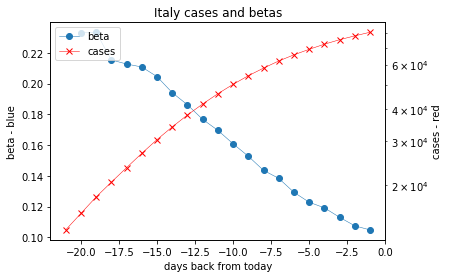

In [166]:
k = 7 # convolution window
threshold = 7500 # ignore days below 3000 cumulative cases
I_ = I[I>threshold]
I_ = convolve(I_, k)
beta_ = get_beta(I_)
x = np.arange(0, len(I_))

plot(x, I_, beta_)

## How does beta decay between first few thousand cases until the peak?  

- Effect of preventive measures    
- Gradual increase in testing wider populations   

If the measures are reasonably effective the decrease in beta could be approximated well by maintaining the following assumption:  
$$ S(t)/n \sim 1 $$  

With this assumption the asymptotic value of beta is gamma. The decrease in beta in the range from first measures until the peak can be (1) linear (not realistic unless extreme freeze takes place), (2) exponential, or (3) power law. Let's test the slowest decay for an upper bound:  
$$ beta(t) - gamma(t) \sim \nu_1 t^{\nu_0} $$  

where $t$ is taken to be the number of days since the first confirmed case  

## Simplest fit: mean square on loglog

---
Using all available data:

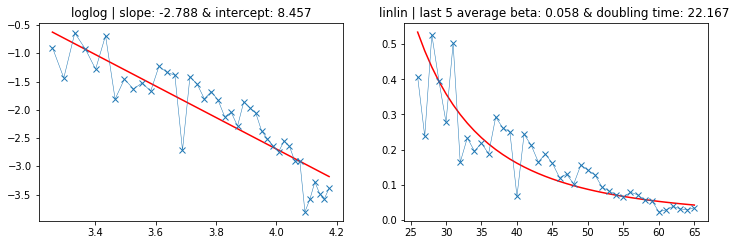

In [167]:
plot_fit(I)

---
Averaging and cutting the beginning:

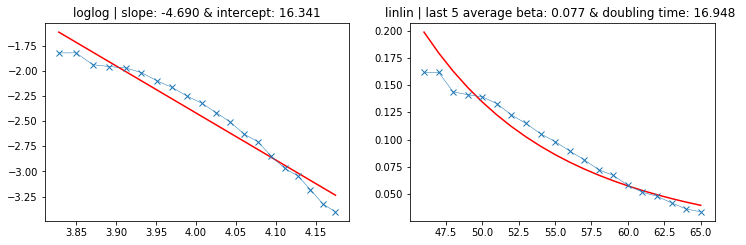

In [168]:
plot_fit(I_)